# A/B-тестирование

**Наша цель:**

- оценить корректность проведения теста и проанализировать его результаты.

*Наши задачи:*

- удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно;

- проверить равномерность распределения пользователей по тестовым группам и правильность их формирования.

**Описание данных:**

*ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;*
 
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

*final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;*

- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

*final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;*

- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

*final_ab_participants.csv — таблица участников тестов.*

- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

**План работы:**

- 1) Ознакомление с данными, проверка на пропуски и дубликаты;

- 2) Предобработка данных;

- 3) Оценка корректности проведения теста;

3.1 Проверка соответствия данных  требованиям технического задания. 

3.2 Проверка времени проведения теста на совпадение с маркетинговыми и другими активностями.

3.3 Проверка аудитории теста на пересечения с конкурирующим тестом и на пользователей, участвующих в двух группах теста одновременно, а также равномерности распределения пользователей по тестовым группам и правильности формирования групп. 

- 4) Исследовательский анализ данных;

4.1 Количество событий на пользователя одинаково распределены в
выборках?

4.2 Как число событий в выборках распределено по дням?

4.3 Как меняется конверсия в воронке в выборках на разных этапах?

4.4 Какие особенности данных нужно учесть, прежде чем приступать к A/B тестированию?

- 5) Оценка результатов A/B-тестирования

5.1 Что можно сказать про результаты A/В-тестирования?

5.2 Проверка статистической разницы долей z-критерием

- 6) Выводы и рекомендации

**Техническое задание**

- Название теста: recommender_system_test;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000;
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:

конверсии в просмотр карточек товаров — событие product_page,

просмотры корзины — product_cart,

покупки — purchase.

## Ознакомление с данными, проверка на пропуски и дубликаты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import datetime as dt
from datetime import datetime, timedelta
import plotly.express as px
import plotly.graph_objects as go
import math as mth
from statsmodels.stats.proportion import proportions_ztest

%config InlineBackend.figure_format = 'retina'

import matplotlib 
matplotlib.style.use('seaborn-pastel')

In [2]:
try:
    marketing_events = pd.read_csv('/datasets/ab_project_marketing_events.csv')
    ab_new_users = pd.read_csv('/datasets/final_ab_new_users.csv')
    ab_events = pd.read_csv('/datasets/final_ab_events.csv')
    ab_participants = pd.read_csv('/datasets/final_ab_participants.csv')
except:
    marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')
    ab_new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
    ab_events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
    ab_participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

In [3]:
#напишем функцию для первоначального анализа и ознакомимся с данными 

def info(df):
    display(df.head())
    print(df.isna().sum())
    print(df.duplicated().sum())
    print(df.info())

In [4]:
info(marketing_events)

name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
None


In [5]:
info(ab_new_users)

user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone

user_id       0
first_date    0
region        0
device        0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
None


In [6]:
info(ab_events)

user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase    99.99
1  7B6452F081F49504  2020-12-07 09:22:53   purchase     9.99
2  9CD9F34546DF254C  2020-12-07 12:59:29   purchase     4.99
3  96F27A054B191457  2020-12-07 04:02:40   purchase     4.99
4  1FD7660FDF94CA1F  2020-12-07 10:15:09   purchase     4.99

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB
None


In [7]:
info(ab_participants)

user_id group                  ab_test
0  D1ABA3E2887B6A73     A  recommender_system_test
1  A7A3664BD6242119     A  recommender_system_test
2  DABC14FDDFADD29E     A  recommender_system_test
3  04988C5DF189632E     A  recommender_system_test
4  482F14783456D21B     B  recommender_system_test

user_id    0
group      0
ab_test    0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB
None


Итак, мы ознакомились с данными, явных дубликатов нет, пропусков во всех датасетах нет, кроме ab_events - пропуски в столбце с деталями (например, для покупок - стоимость в долларах), их количество велико, поэтому удалить эти строки или как-то заполнить мы не можем, это повлияет на исследование, оставим их как есть, необходимо изменить тип столбцов с датами.

## Предобработка данных

In [8]:
#приведем столбцы с датами в данных к нужному типу

marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
ab_new_users['first_date'] = pd.to_datetime(ab_new_users['first_date'])
ab_events['event_dt'] = pd.to_datetime(ab_events['event_dt'])

In [9]:
#проверим за какой период представлены данные

print(ab_new_users['first_date'].min())
print(ab_new_users['first_date'].max())
print(ab_new_users['first_date'].max() - ab_new_users['first_date'].min())

2020-12-07 00:00:00
2020-12-23 00:00:00
16 days 00:00:00


У нас заявлено, что в датасете ab_new_users - все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года, по факту данные о пользователях, зарегистрировавшихся до 23 декабря 2020г.

In [10]:
print(ab_events['event_dt'].min())
print(ab_events['event_dt'].max())
print(ab_events['event_dt'].max() - ab_events['event_dt'].min())

2020-12-07 00:00:33
2020-12-30 23:36:33
23 days 23:36:00


Согласно описанию в датасете ab_events - все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года, по факту данные о событиях лишь до 30 декабря 2020г.

In [11]:
#посмотрим участники каких тестов есть в датасете 

ab_participants.groupby('ab_test').nunique()

user_id  group
ab_test                                
interface_eu_test          11567      2
recommender_system_test     6701      2

У нас есть конкурирующий АБ-тест - это interface_eu_test

In [12]:
#проверим не попали ли какие-то пользователи в 2 теста сразу

ab_participants.groupby('user_id').agg({'ab_test': 'nunique'}).query('ab_test > 1')

ab_test
user_id                  
001064FEAAB631A1        2
00341D8401F0F665        2
003B6786B4FF5B03        2
0082295A41A867B5        2
00E68F103C66C1F7        2
...                   ...
FF7BE2897FC0380D        2
FF9A81323FA67D6E        2
FFC53FD45DDA5EE8        2
FFED90241D04503F        2
FFF28D02B1EACBE1        2

[1602 rows x 1 columns]

1602 пользователя попали в оба теста, разберемся с ними на этапе оценки корректности проведения теста.

Таким образом, мы предобработали данные, выявили расхождения по датам и обнаружили конкурирующий АБ-тест, по данным пунктам разберемся далее на этапе оценки корректности проведения теста.

## Оценка корректности проведения теста

### Проверка соответствия данных  требованиям технического задания.

In [13]:
#возьмем только данные о пользователях теста recommender_system_test

final_ab = ab_participants.query('ab_test == "recommender_system_test"')

In [14]:
#объедим датасеты final_ab и ab_new_users чтобы проверить дату регистрации пользователей нашего теста на соответствие ТЗ

final_ab = final_ab.merge(
        ab_new_users[['user_id', 'first_date', 'region', 'device']], on='user_id', how='left'
    )
final_ab

user_id group                  ab_test first_date     region  \
0     D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07         EU   
1     A7A3664BD6242119     A  recommender_system_test 2020-12-20         EU   
2     DABC14FDDFADD29E     A  recommender_system_test 2020-12-08         EU   
3     04988C5DF189632E     A  recommender_system_test 2020-12-14         EU   
4     482F14783456D21B     B  recommender_system_test 2020-12-14         EU   
...                ...   ...                      ...        ...        ...   
6696  053FB26D6D49EDDC     A  recommender_system_test 2020-12-10  N.America   
6697  9D263B8EF15CF188     B  recommender_system_test 2020-12-16  N.America   
6698  F2FBBA33F37DEC46     A  recommender_system_test 2020-12-18       APAC   
6699  29C92313A98B1176     B  recommender_system_test 2020-12-07       APAC   
6700  6715343AFBA285AE     B  recommender_system_test 2020-12-07        CIS   

       device  
0          PC  
1      iPhone  
2         Mac  
3      iPhone  
4          PC  
...       ...  
6696  Android  
6697      Mac  
6698      Mac  
6699  Android  
6700  Android  

[6701 rows x 6 columns]

In [15]:
print(final_ab['first_date'].max())
print(final_ab['first_date'].min())

2020-12-21 00:00:00
2020-12-07 00:00:00


Условия ТЗ по дате запуска и дате остановки набора новых пользователей выполняется

In [16]:
#объедим датасеты final_ab и ab_events чтобы проверить дату остановки нашего теста на соответствие ТЗ

final_ab = final_ab.merge(
        ab_events[['user_id', 'event_dt', 'event_name', 'details']], on='user_id', how='left'
    )
final_ab

user_id group                  ab_test first_date region  \
0      D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
1      D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
2      D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
3      D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
4      D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
...                 ...   ...                      ...        ...    ...   
27719  6715343AFBA285AE     B  recommender_system_test 2020-12-07    CIS   
27720  6715343AFBA285AE     B  recommender_system_test 2020-12-07    CIS   
27721  6715343AFBA285AE     B  recommender_system_test 2020-12-07    CIS   
27722  6715343AFBA285AE     B  recommender_system_test 2020-12-07    CIS   
27723  6715343AFBA285AE     B  recommender_system_test 2020-12-07    CIS   

        device            event_dt    event_name  details  
0           PC 2020-12-07 14:43:27      purchase    99.99  
1           PC 2020-12-25 00:04:56      purchase     4.99  
2           PC 2020-12-07 14:43:29  product_cart      NaN  
3           PC 2020-12-25 00:04:57  product_cart      NaN  
4           PC 2020-12-07 14:43:27  product_page      NaN  
...        ...                 ...           ...      ...  
27719  Android 2020-12-07 10:12:15         login      NaN  
27720  Android 2020-12-08 22:51:16         login      NaN  
27721  Android 2020-12-09 02:28:03         login      NaN  
27722  Android 2020-12-10 22:55:14         login      NaN  
27723  Android 2020-12-14 12:40:41         login      NaN  

[27724 rows x 9 columns]

In [17]:
print(final_ab['event_dt'].max())
print(final_ab['event_dt'].min())

2020-12-30 12:42:57
2020-12-07 00:05:57


Условие по остановке теста 4 января 2021 года не выполняется, последние события зафиксированы 30 декабря 2020

In [18]:
#посчитаем какая доля пользователей из Европы отобрана в наш тест 

eu_share = round(final_ab.query('region == "EU"').agg({'user_id': 'nunique'})/ab_new_users.query('region == "EU" and first_date <= "2020-12-21"').agg({'user_id': 'nunique'})*100, 2)
eu_share

user_id    15.0
dtype: float64

Условие в тест должно быть отобрано 15% новых пользователей из региона EU выполняется

In [19]:
#проверим из каких еще регионов пользователи в нашем тесте

final_ab.groupby('region').agg({'user_id': 'nunique'})

user_id
region            
APAC            72
CIS             55
EU            6351
N.America      223

Если пользователи из других регионов распределены равномерно между нашими группами А и Б они не помешают тесту

In [20]:
#проверим распределение пользователей из других регионов между группами

users_other_region = final_ab.query('region != "EU"').groupby('group')['user_id'].nunique()
users_other_region

group
A    190
B    160
Name: user_id, dtype: int64

In [21]:
#рассчитаем сколько всего пользователей по группам в нашем тесте

users_group = final_ab.groupby('group')['user_id'].nunique()
users_group

group
A    3824
B    2877
Name: user_id, dtype: int64

In [22]:
#напишем функцию, которая принимает в качестве аргументов 4 числа для z-теста пропорций 

def z_test(successes1, successes2, trials1, trials2, alpha):
    
    alpha = .05 # критический уровень статистической значимости
    
    # пропорция успехов в первой группе:
    p1 = successes1/trials1
    
    # пропорция успехов во второй группе:
    p2 = successes2/trials2
    
    print(successes1, successes2, trials1, trials2)
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # разница пропорций в датасетах
    difference = p1 - p2 
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [23]:
z_test(users_other_region[0],
      users_other_region[1],
      users_group[0],
      users_group[1],
      alpha = 0.05)

190 160 3824 2877
p-значение:  0.2803899103255276
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между долями нет значимой разницы оставляем пользователей из других регионов в тесте

In [24]:
#посмотрим сколько пользователей не совершали событий вообще

final_ab.query('event_dt == "NaT"')['user_id'].nunique()

3026

In [25]:
#посмотрим как эти пользователи распределены между группами

users_no_event = final_ab.query('event_dt == "NaT"').groupby('group')['user_id'].nunique()
users_no_event

group
A    1077
B    1949
Name: user_id, dtype: int64

In [26]:
z_test(users_no_event[0],
      users_no_event[1],
      users_group[0],
      users_group[1],
      alpha = 0.05)

1077 1949 3824 2877
p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница


Таким образом, пользователи, которые не совершали событий вообще неравномерно распределены по группам

In [27]:
#посмотрим на какой день после регистрации пользователи совершают первые свои события

first_events = final_ab.groupby('user_id').agg({'first_date': 'first', 'event_dt': 'min'})
first_events['diff'] = (first_events['event_dt'] - first_events['first_date'])/np.timedelta64(1,'D')

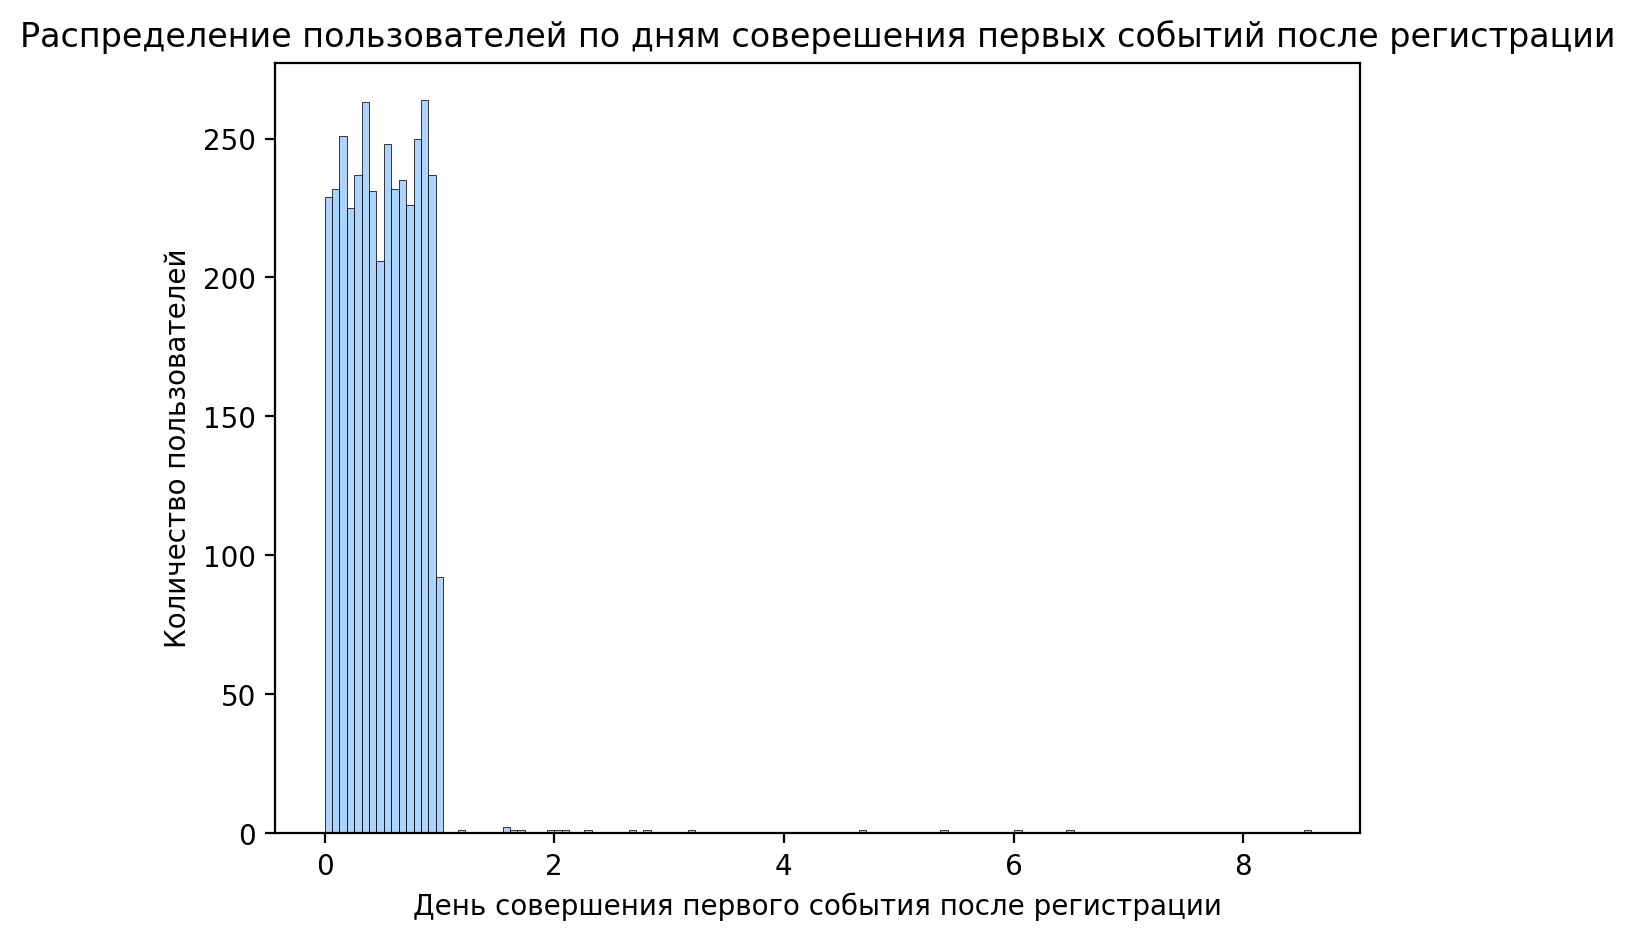

In [28]:
plt.figure(figsize = (7,5))
sns.histplot(x='diff', data=first_events)
plt.xlabel('День совершения первого события после регистрации')
plt.ylabel('Количество пользователей')
plt.title('Распределение пользователей по дням соверешения первых событий после регистрации')
plt.show()

Если мы будем брать только тех, кто все 14 дней в тесте, то потеряем много пользователей. Но мы видим, что в основном пользователи совершают события в первые дни, и мало кому нужно именно 14 дней. Поэтому мы оставляем пользователей, которые не успели прожить 14 дней. Но в дальнейшем анализе мы должны отфильтровать события, которые пользователи совершили после 14 дней от регистрации.

### Проверка времени проведения теста на совпадение с маркетинговыми и другими активностями.

In [29]:
marketing_events.query('start_dt <= "2021-01-04" and finish_dt >= "2020-12-07"')

name        regions   start_dt  finish_dt
0    Christmas&New Year Promo  EU, N.America 2020-12-25 2021-01-03
10  CIS New Year Gift Lottery            CIS 2020-12-30 2021-01-07

Во время проведения нашего теста проводились две маркетинговых акции, посмотрим на динамику количества событий в период акций

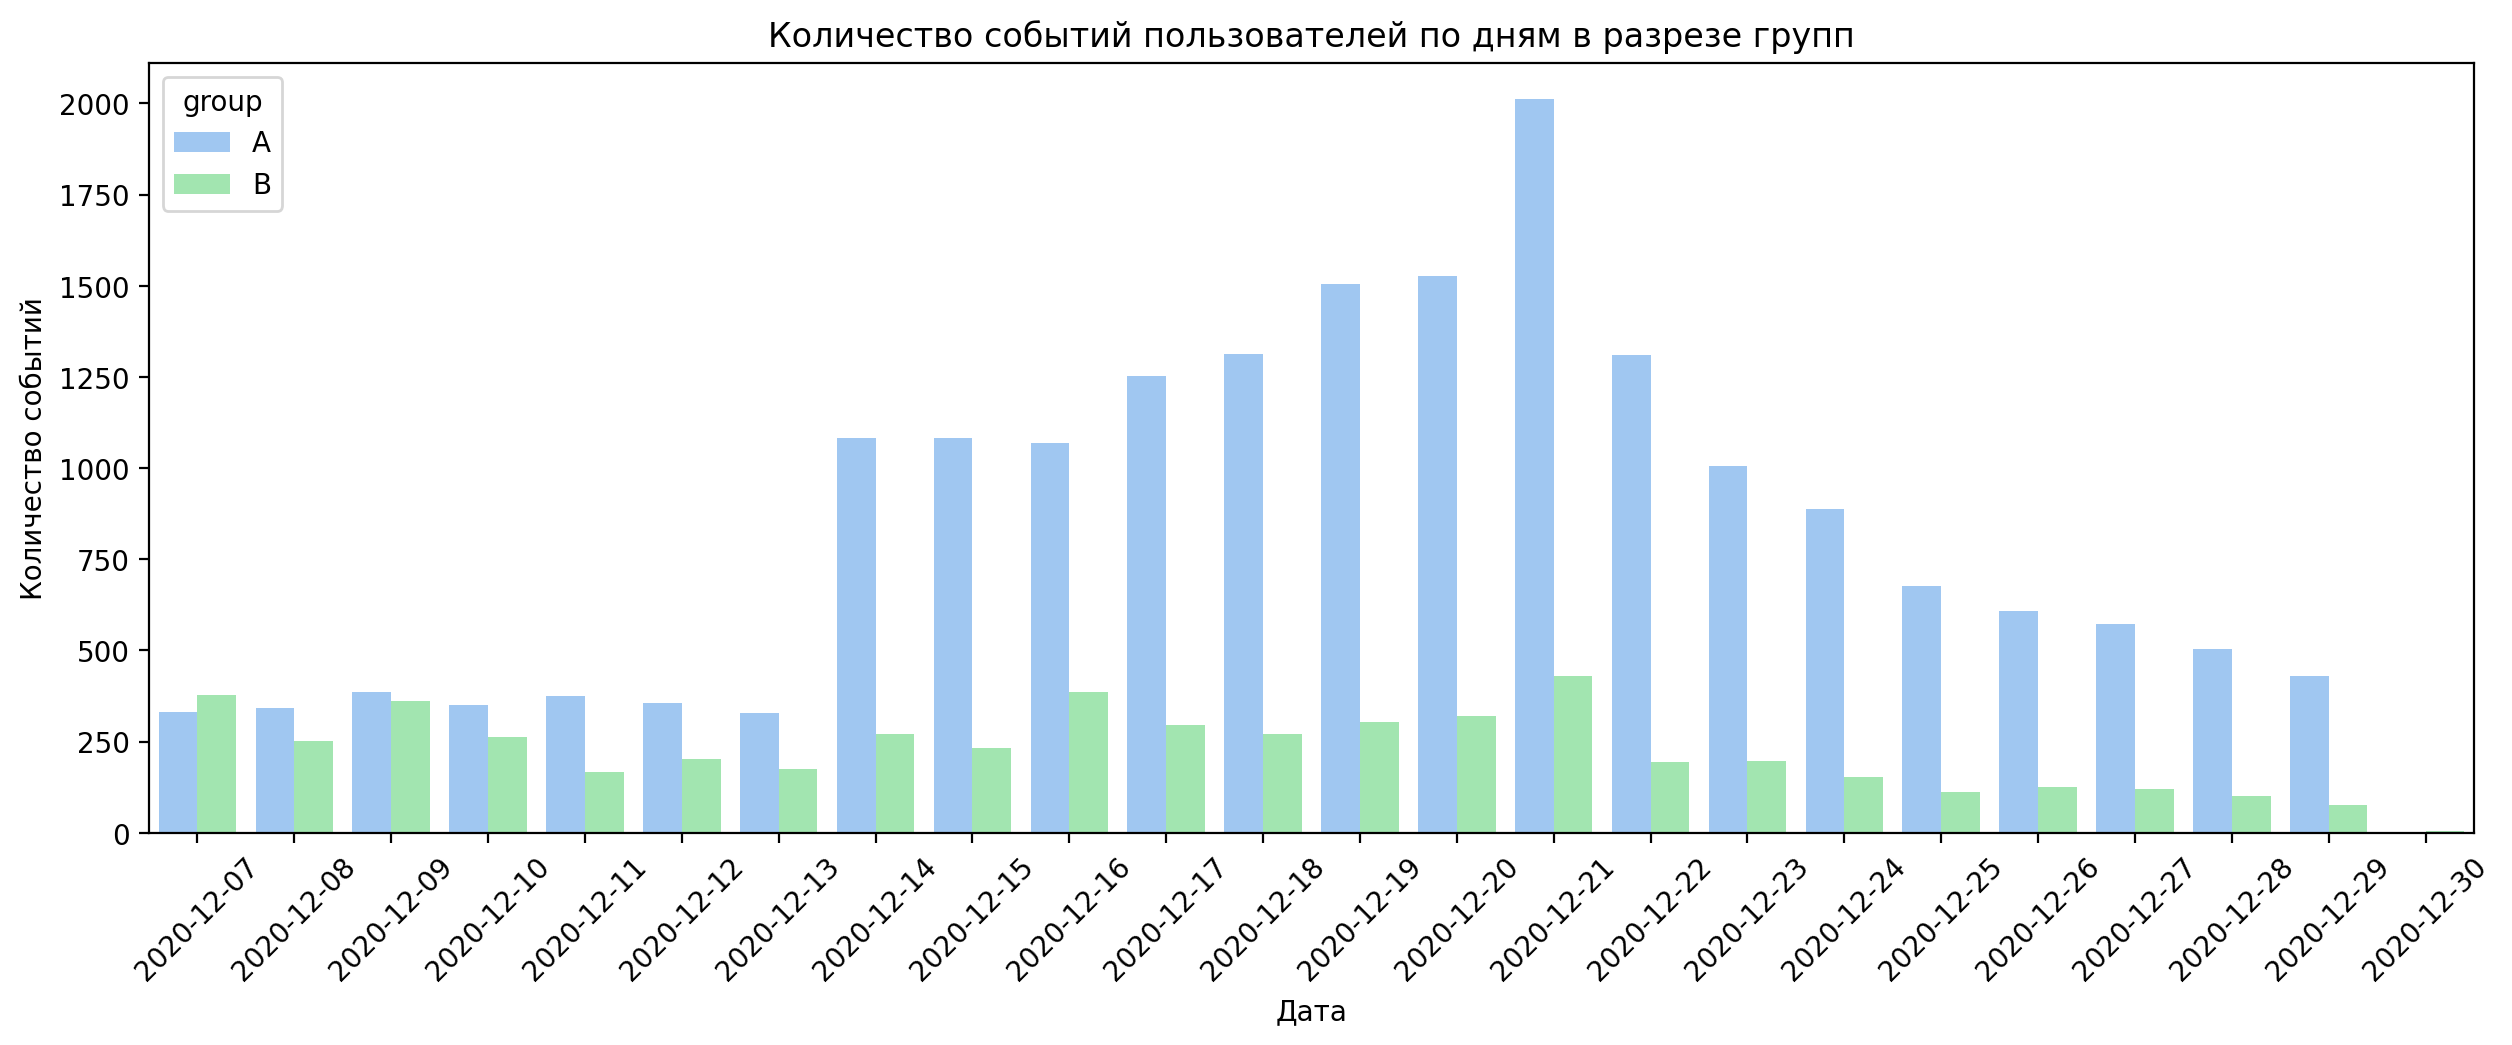

In [30]:
#добавим столбец с датой события

final_ab['event_date'] = final_ab['event_dt'].dt.date

events_count = final_ab.groupby(['event_date', 'group'])['event_name'].count().reset_index()

plt.figure(figsize = (15, 5))
sns.barplot(data = events_count, x = 'event_date', y = 'event_name', hue = 'group')
plt.title('Количество событий пользователей по дням в разрезе групп')
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.xticks(rotation = 45)
plt.show()

Динамика количества событий в период акции одинакова по группам А и Б, значит такие события не помешают нашему тесту.

### Проверка аудитории теста на пересечения с конкурирующим тестом и на пользователей, участвующих в двух группах теста одновременно, а также равномерности распределения пользователей по тестовым группам и правильности формирования групп.

In [31]:
#создадим список пересекающихся c конкурирующим тестом пользователей 

users_two_test = ab_participants.groupby('user_id').agg({'ab_test': 'nunique'}).query('ab_test > 1').index

В нашем тесте - recommender_system_test 6701 пользователь, если мы удалим из него 1602 пользователя, пресекающихся с конкурирующим тестом - interface_eu_test, то у нас останется менее 6000 пользователей, что не соответствует ТЗ, поэтому посмотрим в какие именно группы теста interface_eu_test попали наши пользователи, ведь если они в контрольной группе, это значит что тест interface_eu_test на них никак не повлиял.

In [32]:
#посмотрим в какую группу кокурирующего теста попали эти пользователи

ab_participants.query('ab_test == "interface_eu_test" and user_id in @users_two_test').groupby('group')['user_id'].count()

group
A    819
B    783
Name: user_id, dtype: int64

819 пользователей из конкурирующего теста из группы А, из нашего теста удалим пользователей только из группы Б

In [33]:
#создадим список пользователей из конкурирующего теста из группы B

users_two_test_group_B = ab_participants.query('ab_test == "interface_eu_test" and user_id in @users_two_test and group == "B"')
users_two_test_group_B = users_two_test_group_B['user_id'].tolist()

#удалим из нашего теста пользователей из конкурирующего теста группы Б 

final_ab = final_ab.query('user_id not in @users_two_test_group_B')
final_ab

user_id group                  ab_test first_date region  \
0      D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
1      D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
2      D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
3      D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
4      D1ABA3E2887B6A73     A  recommender_system_test 2020-12-07     EU   
...                 ...   ...                      ...        ...    ...   
27719  6715343AFBA285AE     B  recommender_system_test 2020-12-07    CIS   
27720  6715343AFBA285AE     B  recommender_system_test 2020-12-07    CIS   
27721  6715343AFBA285AE     B  recommender_system_test 2020-12-07    CIS   
27722  6715343AFBA285AE     B  recommender_system_test 2020-12-07    CIS   
27723  6715343AFBA285AE     B  recommender_system_test 2020-12-07    CIS   

        device            event_dt    event_name  details  event_date  
0           PC 2020-12-07 14:43:27      purchase    99.99  2020-12-07  
1           PC 2020-12-25 00:04:56      purchase     4.99  2020-12-25  
2           PC 2020-12-07 14:43:29  product_cart      NaN  2020-12-07  
3           PC 2020-12-25 00:04:57  product_cart      NaN  2020-12-25  
4           PC 2020-12-07 14:43:27  product_page      NaN  2020-12-07  
...        ...                 ...           ...      ...         ...  
27719  Android 2020-12-07 10:12:15         login      NaN  2020-12-07  
27720  Android 2020-12-08 22:51:16         login      NaN  2020-12-08  
27721  Android 2020-12-09 02:28:03         login      NaN  2020-12-09  
27722  Android 2020-12-10 22:55:14         login      NaN  2020-12-10  
27723  Android 2020-12-14 12:40:41         login      NaN  2020-12-14  

[24516 rows x 10 columns]

Проверим равномерно ли рапределены эти 819 пользователей между группами нашего теста

In [34]:
#создадим список пользователей из конкурирующего теста из группы А

users_two_test_group_A = ab_participants.query('ab_test == "interface_eu_test" and user_id in @users_two_test and group == "A"')
users_two_test_group_A = users_two_test_group_A['user_id'].tolist()

In [35]:
#посмотрим в какие группы нашего теста попали эти пользователи

users_group_A = final_ab.query('user_id in @users_two_test_group_A').groupby('group')['user_id'].nunique()
users_group_A

group
A    482
B    337
Name: user_id, dtype: int64

In [36]:
z_test(users_group_A[0],
      users_group_A[1],
      users_group[0],
      users_group[1],
      alpha = 0.05)

482 337 3824 2877
p-значение:  0.27035559328835035
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Таким образом, пользователи равномерно распределены между группами нашего теста, оставляем их 

In [37]:
#проверим не попали ли какие-то пользователи в 2 группы сразу

final_ab.groupby('user_id').agg({'group': 'nunique'}).query('group > 1')

Empty DataFrame
Columns: [group]
Index: []

Пересекающихся пользователей по группам в нашем тесте нет

In [38]:
#посмотрим как распределены пользователи по группам

users_groups = users_group.reset_index()
users_groups['share'] = users_groups['user_id']/users_groups['user_id'].sum()
users_groups

group  user_id     share
0     A     3824  0.570661
1     B     2877  0.429339

Распределение в группы не равномерное, группа А больше Б примерно на треть

Для дальнейшего анализа отфильтруем события старше 14 дней от регистрации пользователя

In [39]:
#посчитаем временной промежуток между датой регистрации и датой события

pd.set_option('mode.chained_assignment', None)

final_ab['event_date'] = pd.to_datetime(final_ab['event_date'])
final_ab['delta'] = (final_ab['event_date'] - final_ab['first_date'])/np.timedelta64(1,'D')

#отбросим события, которые произошли после 14 дней от того момента, как был зарегистрирован пользователь 
#и соответственно уйдут пользователи которые не совершали ни одного события

filtered_ab = final_ab.query('delta < 14')
users_groups_filtered = filtered_ab.groupby('group')['user_id'].nunique()
users_groups_filtered

group
A    2422
B     822
Name: user_id, dtype: int64

## Исследовательский анализ данных

### Количество событий на пользователя одинаково распределены в выборках?

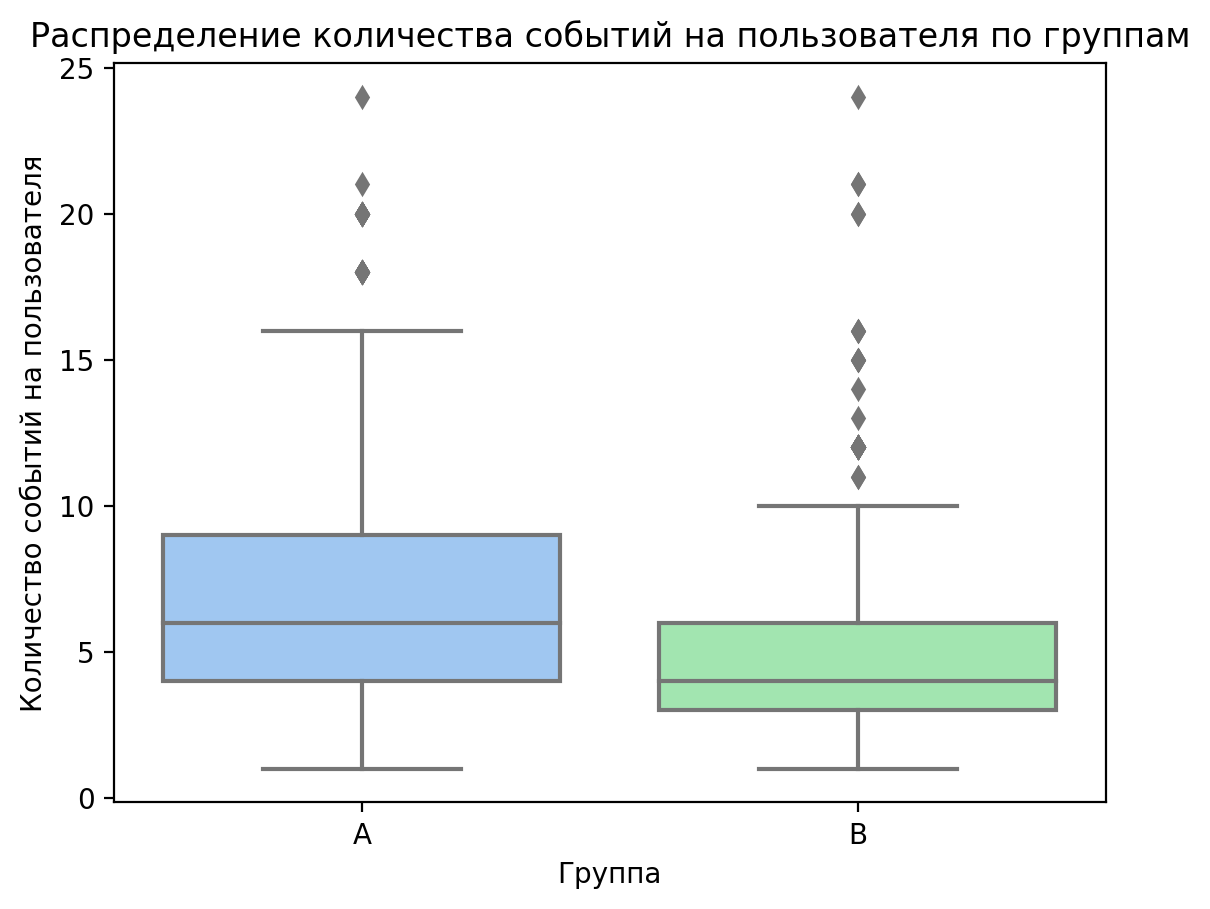

In [40]:
filtered_ab_box = filtered_ab.pivot_table(index = 'user_id', columns= 'group', values='event_name', aggfunc='count')
sns.boxplot(data=filtered_ab_box)
plt.title('Распределение количества событий на пользователя по группам')
plt.ylabel('Количество событий на пользователя')
plt.xlabel('Группа')
plt.show() 

По графику мы видим, что количество событий на пользователя по разному распределены в выборках

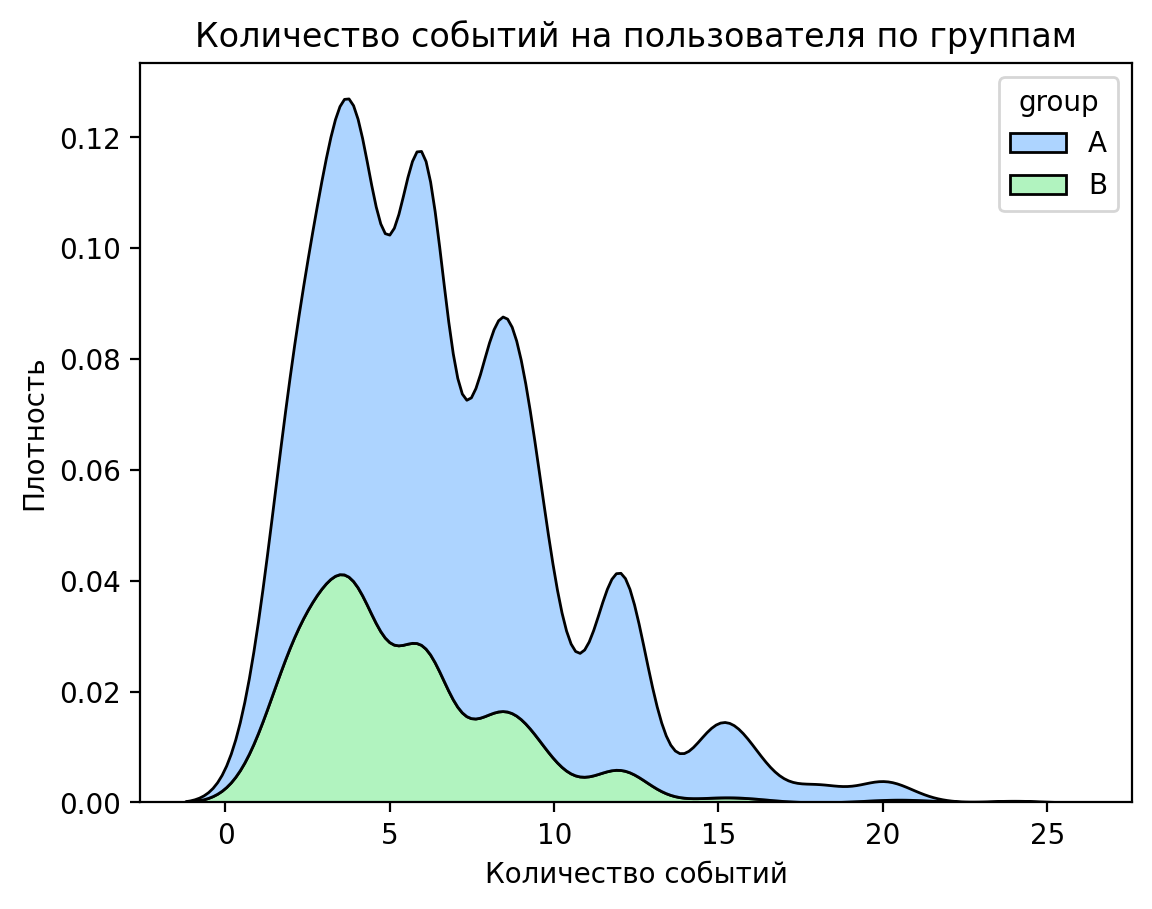

In [41]:
#построим график для визуализации количества событий на пользователя по группам

events_count_group = filtered_ab.groupby(['user_id', 'group']).agg({'event_name': 'count'}).reset_index()

sns.kdeplot(data=events_count_group, x='event_name', hue='group', multiple='stack')
plt.title('Количество событий на пользователя по группам')
plt.ylabel('Плотность')
plt.xlabel('Количество событий')
plt.show()

С помощью критерия Манна-Уитни проверим разницу в количестве событий на пользователя по группам

H_0: Между количеством событий на пользователя в группе А и количеством событий на пользователя в группе В нет статистически значимой разницы

H_1: Между количеством событий на пользователя в группе А и количеством событий на пользователя в группе В есть разница

In [42]:
events_A = events_count_group.query('group == "A"')
events_B = events_count_group.query('group == "B"')

alpha = 0.05  # критический уровень статистической значимости

results = st.mannwhitneyu(events_A['event_name'].tolist(), events_B['event_name'].tolist())

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  6.844894136723494e-27
Отвергаем нулевую гипотезу: разница статистически значима


In [43]:
#посчитаем среднее число событий на пользователя только для тех пользователей, которые совершали события

round(events_count_group.groupby('group')['event_name'].mean())

group
A    7.0
B    5.0
Name: event_name, dtype: float64

In [44]:
#посчитаем среднее число событий на пользователя для всех пользователей

events_count_all_users = final_ab.groupby(['user_id', 'group']).agg({'event_name': 'count'}).reset_index()
round(events_count_all_users.groupby('group')['event_name'].mean())

group
A    5.0
B    2.0
Name: event_name, dtype: float64

Таким образом, разница в количестве событий на пользователя по группам статистически значима. В группе А количество событий на пользователя больше чем в группе Б, в среднем 7 событий на пользователя, против 5. Если взять всех пользователей, учитывая тех кто не совершал событий, тогда средние показатели составят 5 событий на пользователя для группы А и 2 события для группы Б.

### Как число событий в выборках распределено по дням?

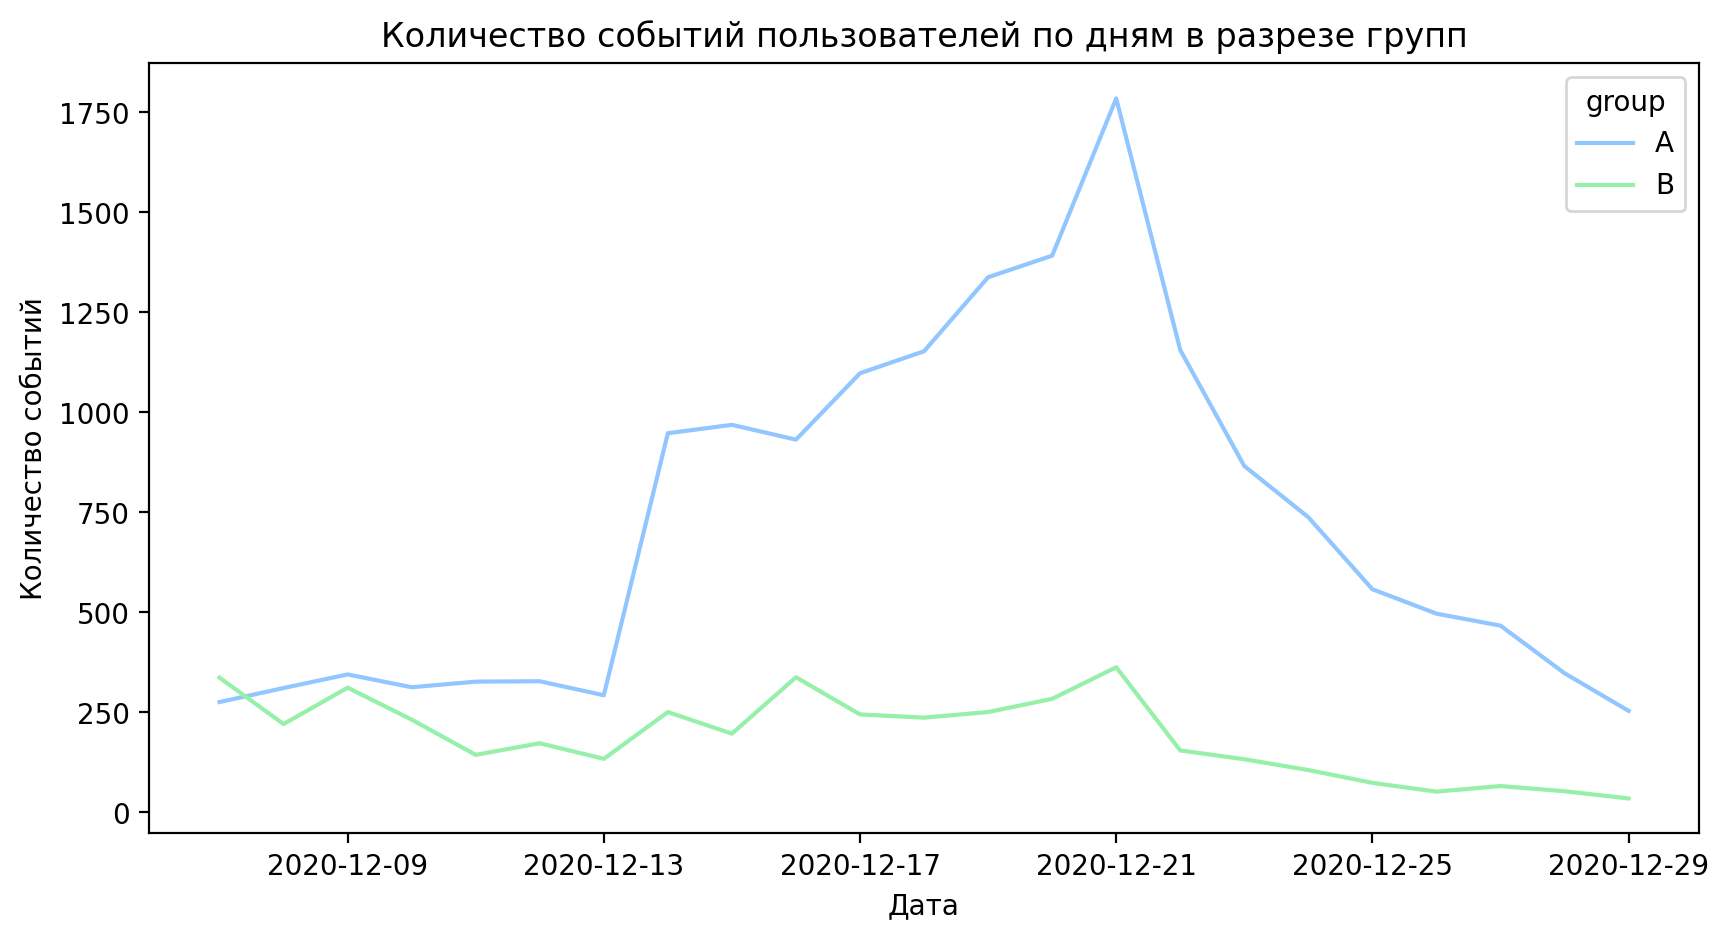

In [45]:
events_count_filtered = filtered_ab.groupby(['event_date', 'group'])['event_name'].count().reset_index()

plt.figure(figsize = (10, 5))
sns.lineplot(data = events_count_filtered, x = 'event_date', y = 'event_name', hue = 'group')
plt.title('Количество событий пользователей по дням в разрезе групп')
plt.ylabel('Количество событий')
plt.xlabel('Дата')

plt.show()

Отметим на графике всплекс событий с 14 декабря, пик 21 декабря и далее снижение активности в группе А, а в группе В события распределены по времени более равномерно.

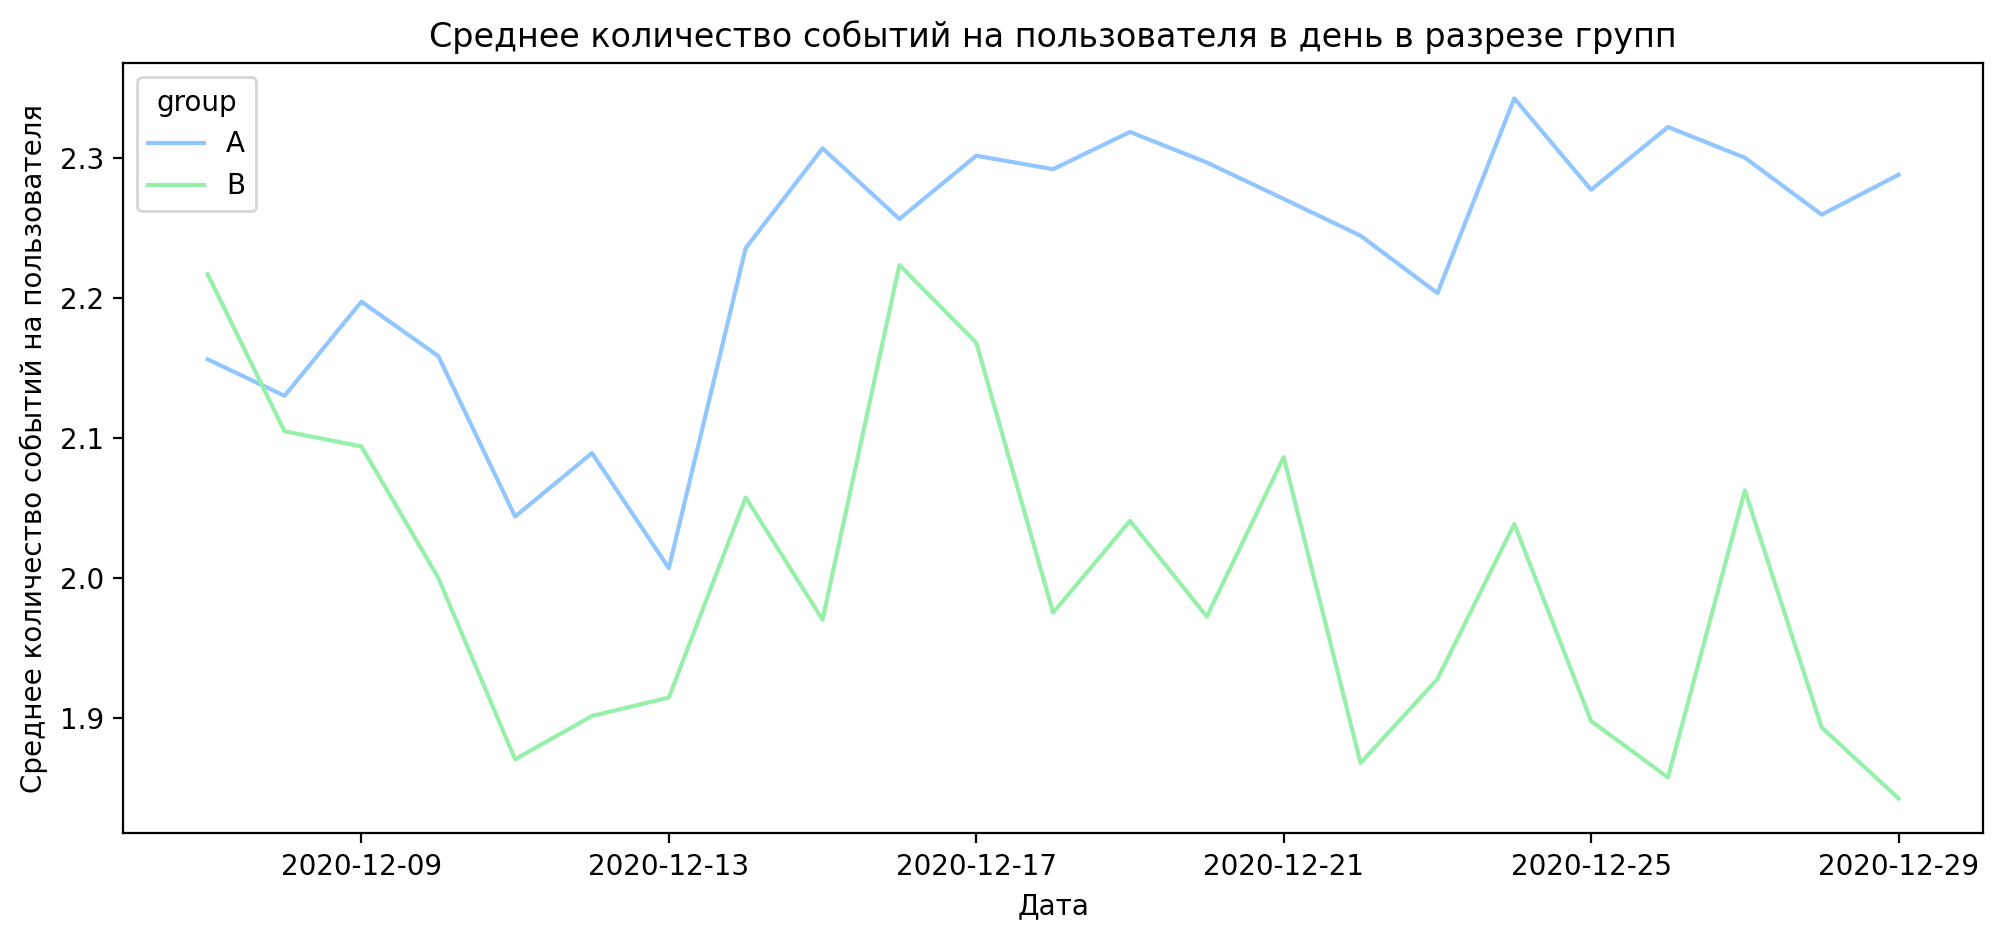

In [46]:
#рассмотрим среднее количество событий в день на пользователя по группам

events_count_filtered2 = filtered_ab.groupby(['event_date', 'group']).agg({'user_id': ['count', 'nunique']}).reset_index()
events_count_filtered2.columns = [x[1] if x[1] else x[0] for x in events_count_filtered2.columns]  
events_count_filtered2['mean'] = events_count_filtered2['count']/events_count_filtered2['nunique']

plt.figure(figsize = (12, 5))
sns.lineplot(data = events_count_filtered2, x = 'event_date', y = 'mean', hue = 'group')
plt.title('Среднее количество событий на пользователя в день в разрезе групп')
plt.ylabel('Среднее количество событий на пользователя')
plt.xlabel('Дата')

plt.show()

В целом среднее число событий на пользователя варьируется по дням. В группе А мы видим увеличение после 13 декабря и дальнейшую тенденцию к росту, а в группе Б, которая вначале была даже выше А произошел спад активности, некоторое увеличение после 11 числа и опять спад после 16 декабря и дальнейшая тенденция к падению.

### Как меняется конверсия в воронке в выборках на разных этапах?

In [47]:
#посчитаем сколько пользователей совершали каждое из событий по группам

funnel = filtered_ab.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').reset_index().reindex([0,2,1,3])
funnel

group    event_name     A    B
0             login  2422  821
2      product_page  1571  459
1      product_cart   728  225
3          purchase   773  226

Мы видим, что покупок оказалось больше, чем просмотров корзины, вероятно в интернет-магазине реализована возможность быстрой покупки прямо со страницы товара, минуя корзину.

In [48]:
#посчитаем долю пользователей, которые хоть раз совершали событие

funnel['users_share_A'] = round(funnel['A']/users_groups_filtered[0], 2)*100
funnel['users_share_B'] = round(funnel['B']/users_groups_filtered[1], 2)*100
funnel

group    event_name     A    B  users_share_A  users_share_B
0             login  2422  821          100.0          100.0
2      product_page  1571  459           65.0           56.0
1      product_cart   728  225           30.0           27.0
3          purchase   773  226           32.0           27.0

In [49]:
#построим воронку

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Воронка группы А',
    y = funnel['event_name'],
    x = funnel['A'],
    textinfo = 'value+percent initial',
    marker = {'color': 'blue'}
))

fig.add_trace(go.Funnel(
    name = 'Воронка группы B',
    y = funnel['event_name'],
    x = funnel['B'],
    textinfo = "value+percent initial",
    marker = {'color': 'green'}
))

fig.update_layout(
    title=dict(text='Воронка событий по группам')
)

fig.show()

In [50]:
#добавим в таблицу потери при переходе

funnel['users_share_next_step_A'] = round(funnel['A']/funnel['A'].shift(periods=1, fill_value=funnel['A'][0]), 2)*100
funnel['losess_A'] = 100 - funnel['users_share_next_step_A']
funnel['users_share_next_step_B'] = round(funnel['B']/funnel['B'].shift(periods=1, fill_value=funnel['B'][0]), 2)*100
funnel['losess_B'] = 100 - funnel['users_share_next_step_B']
funnel

group    event_name     A    B  users_share_A  users_share_B  \
0             login  2422  821          100.0          100.0   
2      product_page  1571  459           65.0           56.0   
1      product_cart   728  225           30.0           27.0   
3          purchase   773  226           32.0           27.0   

group  users_share_next_step_A  losess_A  users_share_next_step_B  losess_B  
0                        100.0       0.0                    100.0       0.0  
2                         65.0      35.0                     56.0      44.0  
1                         46.0      54.0                     49.0      51.0  
3                        106.0      -6.0                    100.0       0.0

Вывод: конверсия в просмотр карточек товара равна 65% для группы А и 56 - для Б, конверсия в просмотр корзины - 30% и 27%, для групп А и Б соответсвенно, и наконец конверсия в покупку 32% в группе А и 27% в группе Б от начального шага воронки - залогинившихся пользователей.

### Какие особенности данных нужно учесть, прежде чем приступать к A/B тестированию?

Подводя итог исследовательского анализа необходимо помнить, что дата остановки нашего теста 4 января 2021г., но по факту у нас есть данные только по 30 декабря 2020г, таким образом, некоторые пользователи до 4 января все же могли дойти до покупки, что повлияло бы на ожидаемый еффект. 

Так же нужно учитывать деление на группы - распределение в группы не равномерное, группа А больше Б примерно на треть. 

Техническое задание по ожидаемому количеству участников не выполняется, после всех фильтраций осталось 5918 пользователей и 3026 из них не попали в воронку, потому что не совершали никаких событий вообще. 

Покупок оказалось больше, чем просмотров корзины, вероятно в интернет-магазине реализована возможность быстрой покупки прямо со страницы товара, минуя корзину.

И наконец, в группе А пользователи более активны и совершают в среднем 7 событий, против 5 для группы Б.

## Оценка результатов A/B-тестирования

### Что можно сказать про результаты A/В-тестирования?

Ожидаемый эффект, что за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
конверсии в просмотр карточек товаров, просмотры корзины и покупки - не оправдался. Группа Б показывает результаты хуже чем группа А на всех этапах воронки.

### Проверка статистической разницы долей z-критерием

In [51]:
#применим попровку Бонферрони к критическому уровню статистической значимости

alpha = 0.05
m = 3
print(f"Bonferroni: {alpha / m:.5f}")

Bonferroni: 0.01667


H_0: Конверсия в просмотр контактов для пользователей группы А и конверсия для пользователей группы В одинаковы

H_1: Конверсии в просмотр контактов пользователей группы А и пользователей группы В различаются

In [52]:
#проверим разницу в конверсии для просмотров карточек товара в группах 

z_test(funnel['A'][2],
      funnel['B'][2],
      users_groups_filtered[0],
      users_groups_filtered[1],
      alpha = 0.016)

1571 459 2422 822
p-значение:  3.8415005565450855e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


H_0: Конверсия в просмотр корзины для пользователей группы А и конверсия для пользователей группы В одинаковы

H_1: Конверсии в просмотр корзины пользователей группы А и пользователей группы В различаются

In [53]:
#проверим разницу в конверсии для просмотров корзины в группах 

z_test(funnel['A'][1],
      funnel['B'][1],
      users_groups_filtered[0],
      users_groups_filtered[1],
      alpha = 0.016)

728 225 2422 822
p-значение:  0.14412076974264498
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


H_0: Конверсия в покупку для пользователей группы А и конверсия для пользователей группы В одинаковы

H_1: Конверсии в покупку пользователей группы А и пользователей группы В различаются

In [54]:
#проверим разницу в конверсии для покупок в группах

z_test(funnel['A'][3],
      funnel['B'][3],
      users_groups_filtered[0],
      users_groups_filtered[1],
      alpha = 0.016)

773 226 2422 822
p-значение:  0.01764968717521609
Отвергаем нулевую гипотезу: между долями есть значимая разница


Выводы: конверсия по группам А и Б различается для просмотров карточек товара и для покупок, для просмотра корзины нет оснований считать доли разными.

## Выводы и рекомендации

Не смотря на все особенности в данных A/В-тестирования мы засчитываем результаты теста и рекомендуем его завершить. Внедрение улучшенной рекомендательной системы не привело к ожидаемому эффекту.